### Goal 
This is my first pass at learning about Conformal Predictions. I hope this notebook serves a good starting point to play around with the procedure and get more familiar with how to think about how to use the output for investigating model performance and improvements.

### Resources
* [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511)

# Installs and Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [3]:
pd.set_option('display.max_columns', None)

# Read in Data

In [4]:
train = pd.read_csv('../input/playground-series-s3e23/train.csv')\
          .drop('id', axis=1)
train.shape

(101763, 22)

# Convert Dependent Variable

In [5]:
train['defects'] = train['defects'].astype(int)

In [6]:
train['defects'].value_counts(normalize=True)

defects
0    0.773356
1    0.226644
Name: proportion, dtype: float64

# X/y

In [7]:
X = train.drop('defects', axis=1)
y = train['defects']

# Conformal Process

1. Split data into train, calibration, and val sets
1. Train xgboost model on train data
1. Generate model outputs with calibration data
1. Calculate score on calibration data
1. Calculate q from scores
1. Generate prediction sets for val data

#### Split data

In [8]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_cal, X_val, y_cal, y_val = train_test_split(X_, y_, test_size=0.5, random_state=42, stratify=y_)
print(X_train.shape, X_cal.shape, X_val.shape)

(71234, 21) (15264, 21) (15265, 21)


#### Train baseline model

These are just handpicked hyperparameters. We could certainly tune them in the future.

In [9]:
xgb = XGBClassifier(n_estimators=1000, 
                    learning_rate=0.1, 
                    max_depth=7, 
                    subsample=0.90,
                    n_jobs=-1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### Calibration Outputs

A lot of times we would just gather the positive class outputs, but here we need to generate scores for the actual class {no defect, defect}. So we will include both columns from predict_proba().

In [10]:
cal_preds = xgb.predict_proba(X_cal)

#### Calibration Scores

In [11]:
n = len(y_cal)
alpha = 0.1 # want our coverage to be 90%

In [12]:
y_cal = np.array(y_cal)
cal_scores = 1 - cal_preds[np.arange(n), y_cal]

#### Calculate q

In [13]:
q_level = np.ceil((n+1)*(1-alpha))/n
qhat=np.quantile(cal_scores, q_level, method='higher')

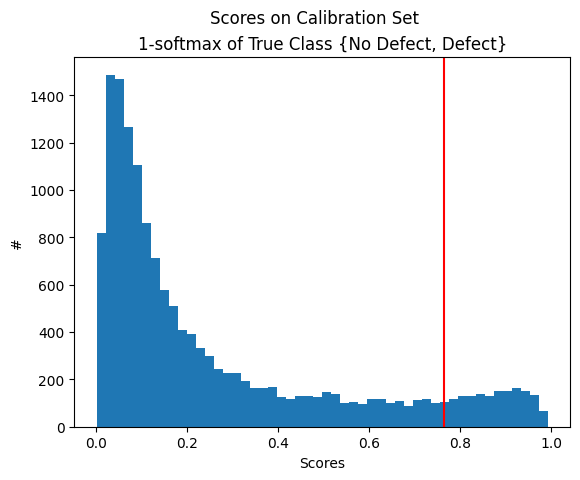

In [14]:
plt.hist(cal_scores, bins=50)
plt.axvline(x=qhat, c='r')
plt.title('1-softmax of True Class {No Defect, Defect}')
plt.suptitle('Scores on Calibration Set')
plt.xlabel('Scores')
plt.ylabel("#")
plt.show()

In [15]:
print(q_level, qhat)

0.9000917190775681 0.7657927


#### Generate Prediction Sets

In [16]:
val_preds = xgb.predict_proba(X_val)
prediction_sets = (val_preds >= (1-qhat)).astype(int)

In [17]:
np.mean(prediction_sets, axis=0)

array([0.94857517, 0.30219456])

# Conformal Evaluation

## First let's create a validation dataframe for summary info needed.

In [18]:
def prediction_group(p1, p2):
    if p1+p2 == 2:
        return 'both'
    elif p1 == 1:
        return 'non_defect'
    else:
        return 'defect'
    
def true_label_covered(y, pred_set):
    if pred_set == 'non_defect':
        if y == 0:
            return 1
        else:
            return 0
    elif pred_set == 'defect':
        if y == 1:
            return 1
        else:
            return 0
    else:
        return 1

In [19]:
val_summary = pd.DataFrame({'y':y_val,
                            'yhat':val_preds[:, 1],
                            'non_defect_set':prediction_sets[:, 0],
                            'defect_set':prediction_sets[:, 1]})
val_summary['set_size'] = val_summary[['non_defect_set','defect_set']].sum(axis=1)
val_summary['prediction_group'] = val_summary[['non_defect_set','defect_set']].apply(lambda x: prediction_group(x[0],x[1]), axis=1)
val_summary['true_label_in_set'] = val_summary[['y','prediction_group']].apply(lambda x: true_label_covered(x[0],x[1]), axis=1)

In [20]:
val_summary.head()

,y,yhat,non_defect_set,defect_set,set_size,prediction_group,true_label_in_set
27821,0,0.101871,1,0,1,non_defect,1
22448,0,0.522188,1,1,2,both,1
7654,0,0.085071,1,0,1,non_defect,1
48086,0,0.132984,1,0,1,non_defect,1
19973,0,0.148098,1,0,1,non_defect,1


## Adaptivity

The less confident a model is in its prediction the wider the prediction set should be. If the model is confident, it should have a smaller prediction set. Therefore we can take a look at how our prediction sets are distributed. However, just because the prediction sets are wide doesn't necessarily mean they are any good. The more difficult inputs should correspond with wider prediction sets. We can check that with stratified metrics.

#### Methods for evaluating adaptivity
1. Plot histogram of set sizes
1. Calculate stratified metrics

### Set Size Histogram

In [21]:
val_summary['set_size'].value_counts(normalize=True)

set_size
1    0.74923
2    0.25077
Name: proportion, dtype: float64

### Stratified Metrics

#### First check the lesser property of marginal coverage

In [22]:
np.mean(val_summary['true_label_in_set'])

0.9023910907304291

Very close to our ~90% coverage we wanted!

#### Now we can check for the stronger property of conditional coverage

#### Feature-stratified Coverage (FSC) Metric

Here we need to create groups for our features, and then calculate the coverage for each of the groups. We can start by just binning our features into 4 quartiles. Maybe another option could be clustering our records together with MiniSOM.

In [23]:
for c in X_val.columns:
    groups = pd.qcut(X_val[c], q=4, labels=False, duplicates='drop')
    temp = pd.concat([groups, val_summary['true_label_in_set']], axis=1)
    coverages = temp.groupby(c)['true_label_in_set']\
                    .agg(['count','mean'])
    print(c)
    print(coverages)
    print('')
    print('')

loc
     count      mean
loc                 
0     4207  0.933444
1     3514  0.894138
2     3832  0.872651
3     3712  0.905711


v(g)
      count      mean
v(g)                 
0      5725  0.912140
1      2411  0.900041
2      3494  0.902404
3      3635  0.888583


ev(g)
       count      mean
ev(g)                 
0      11880  0.904293
1       3385  0.895716


iv(g)
       count      mean
iv(g)                 
0       8685  0.907311
1       3487  0.891884
2       3093  0.900420


n
   count      mean
n                 
0   3969  0.925422
1   3692  0.910888
2   3813  0.879622
3   3791  0.892904


v
   count      mean
v                 
0   3824  0.928347
1   3814  0.910593
2   3813  0.877787
3   3814  0.892764


l
   count      mean
l                 
0   4950  0.898586
1   3314  0.887749
2   3583  0.902875
3   3418  0.921592


d
   count      mean
d                 
0   3862  0.921802
1   3820  0.907853
2   3772  0.887328
3   3811  0.892154


i
   count      mean
i            

Honestly we see pretty good coverage here. We have some groups that hover around 90% +- 3%.

#### Size-stratified Coverage (SSC) Metric

In [24]:
val_summary.groupby('set_size')['true_label_in_set'].agg(['count','mean'])

,count,mean
set_size,,
1,11437,0.869721
2,3828,1.000000


#### Prediction/True Label stratified (addressed in Class-Conditioned Conformal Prediction section)

In [25]:
val_summary.groupby('y')['true_label_in_set'].agg(['count','mean'])

,count,mean
y,,
0,11805,0.982973
1,3460,0.627457


In [26]:
val_summary.groupby('prediction_group')['true_label_in_set'].agg(['count','mean'])

,count,mean
prediction_group,,
both,3828,1.000000
defect,785,0.743949
non_defect,10652,0.878990


So here we see that neither the true labels or our predicted classes have the desired coverage. The negative class has very high coverage, which is great. Ideally we end up with positive class having much better coverage, and closer to our alpha level. Later we will look at class-conditioned conformal prediction.

### Clustering on Features colored by Set-Size

In [27]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [28]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_val)

In [29]:
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(X_scaled)

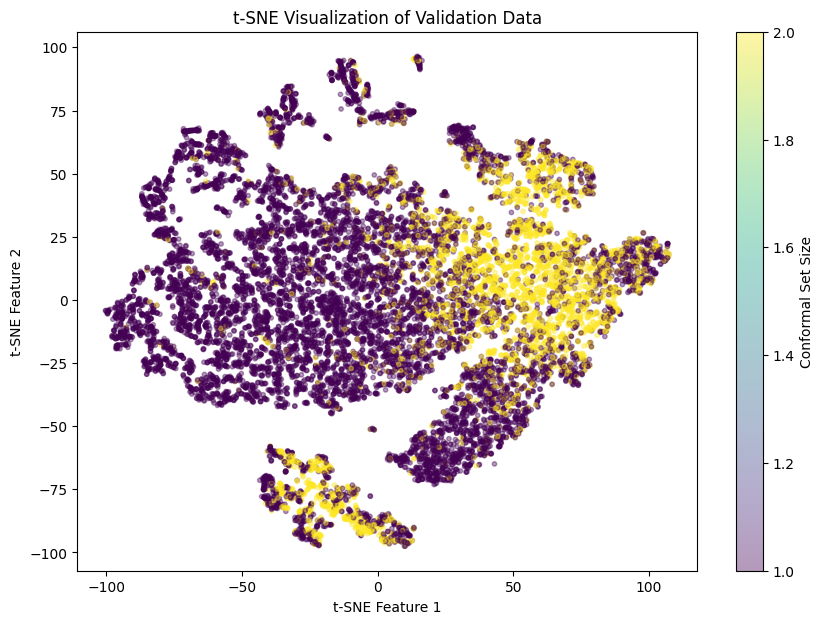

In [30]:
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=val_summary['set_size'], s=10, cmap='viridis', alpha=0.4)
plt.title('t-SNE Visualization of Validation Data')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='Conformal Set Size')
plt.show()

I tried using DBSCAN to produce clusters with this TNSE data, but didn't come up with anything useful. Visually it seems like there are a couple dense areas mostly of uncertain predictions (set size of 2). Would be helpful to narrow in to this set and see how the features differ from the more certain regions.

### Are there features associated with uncertainty?

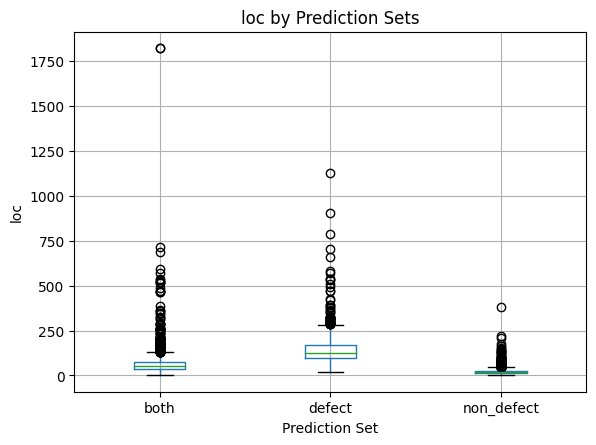

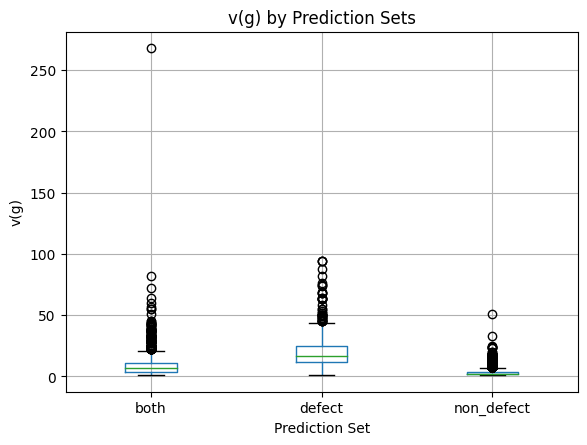

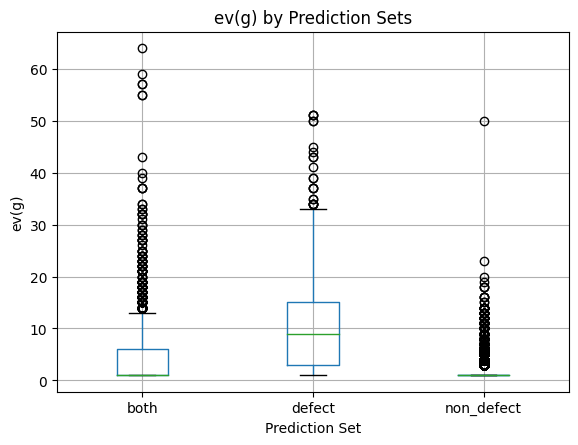

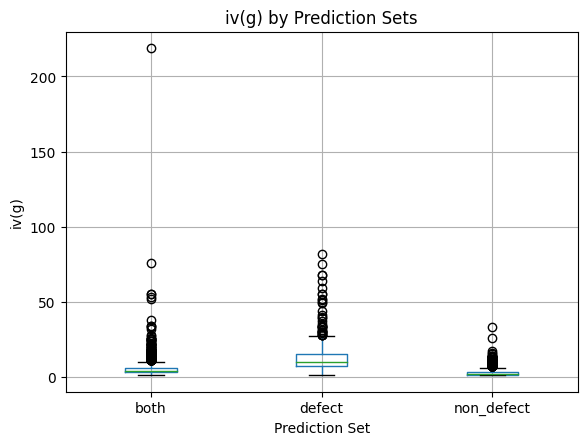

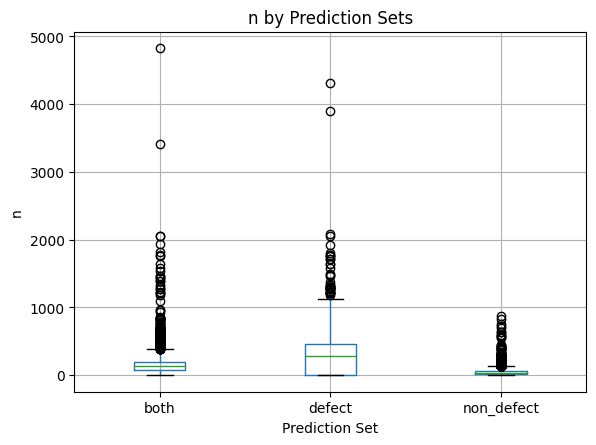

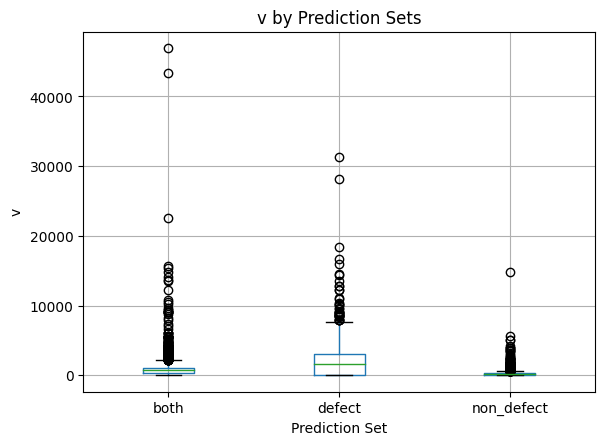

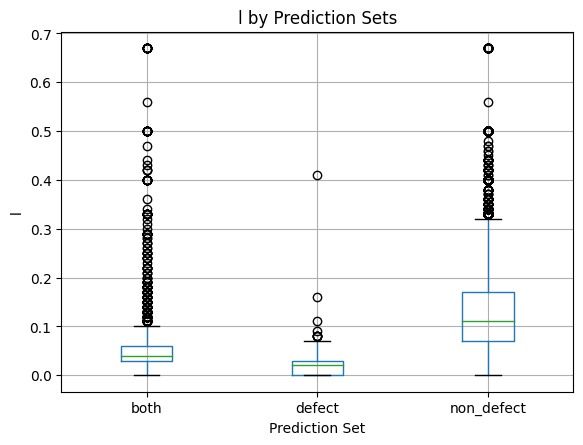

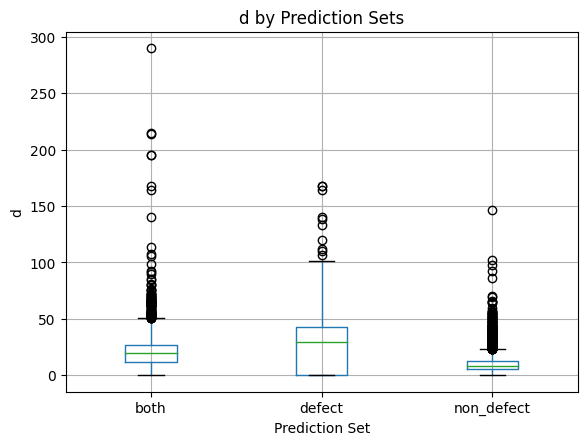

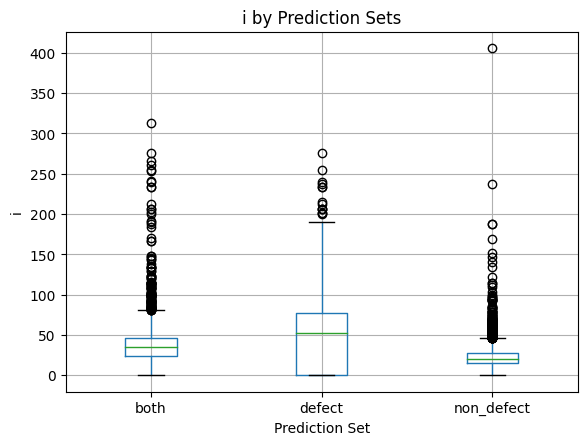

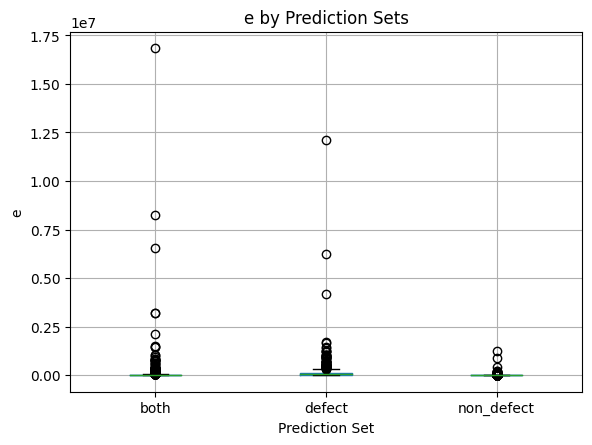

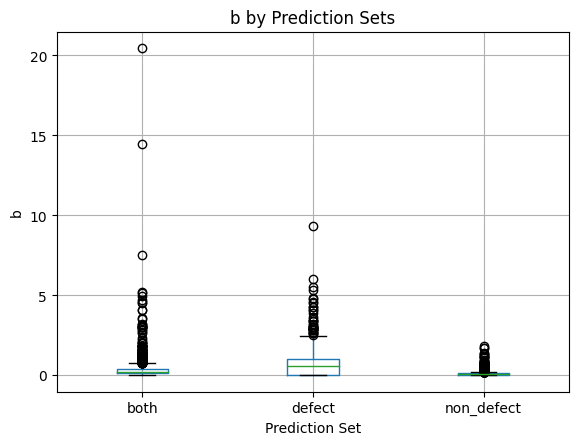

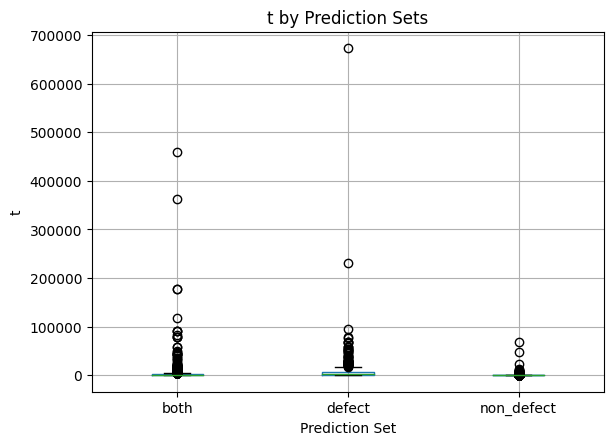

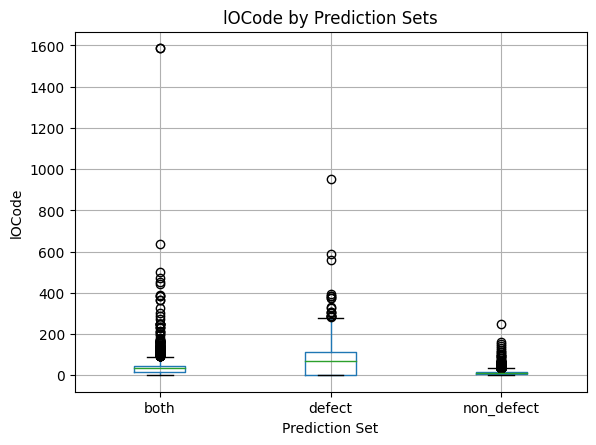

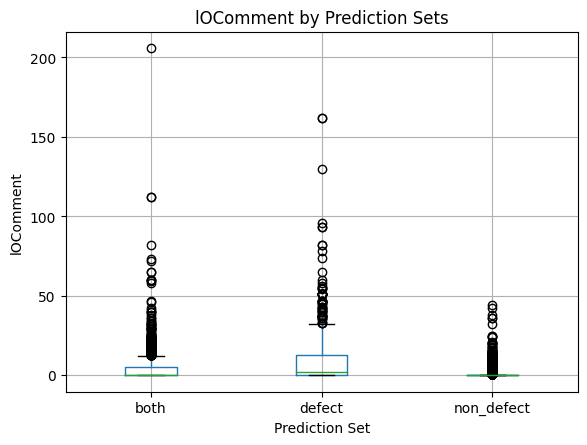

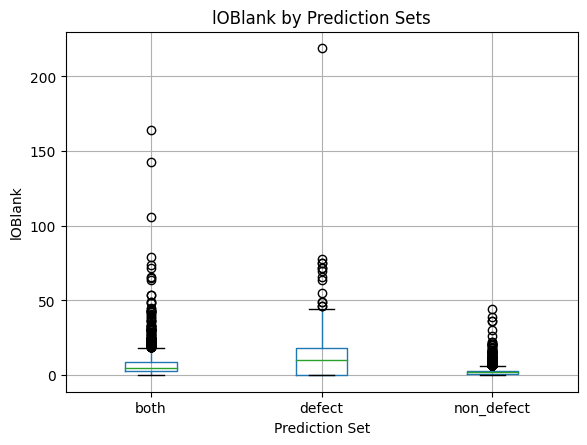

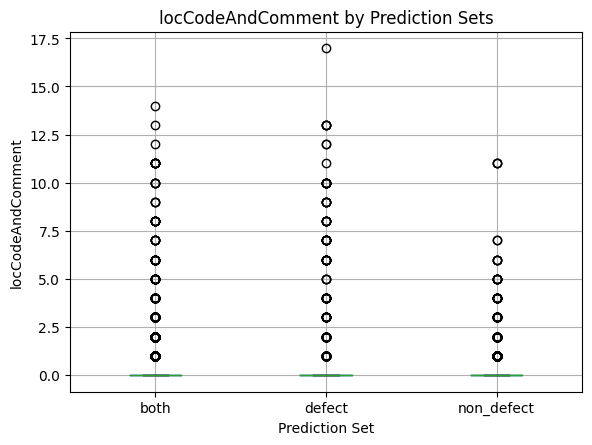

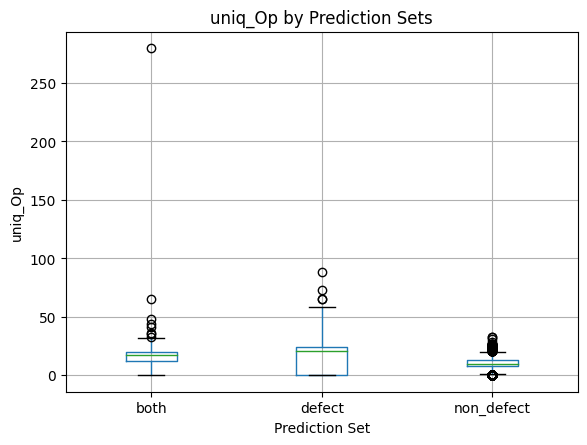

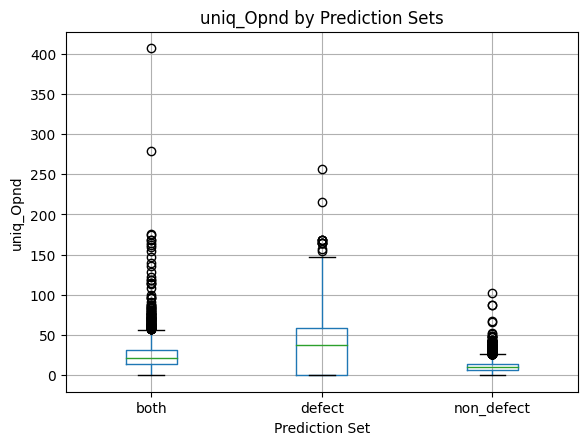

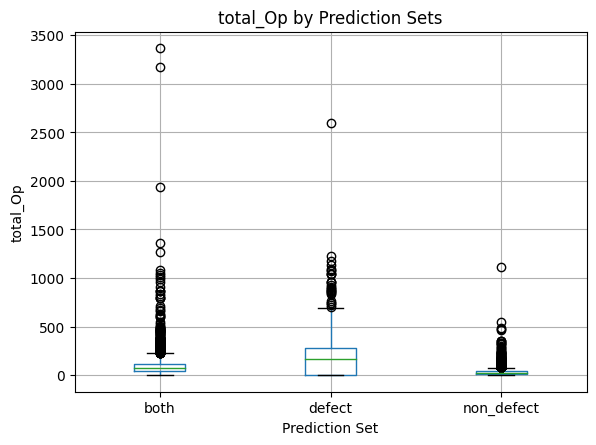

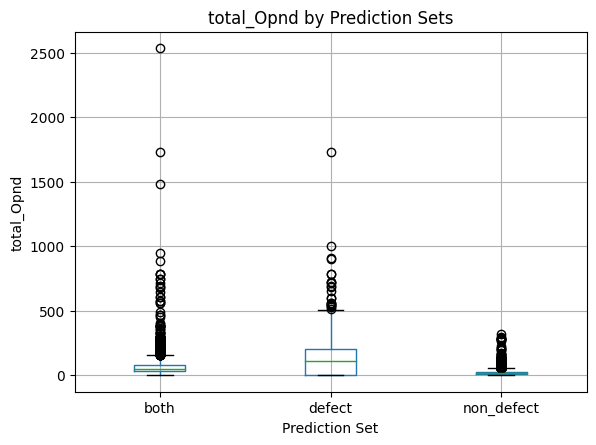

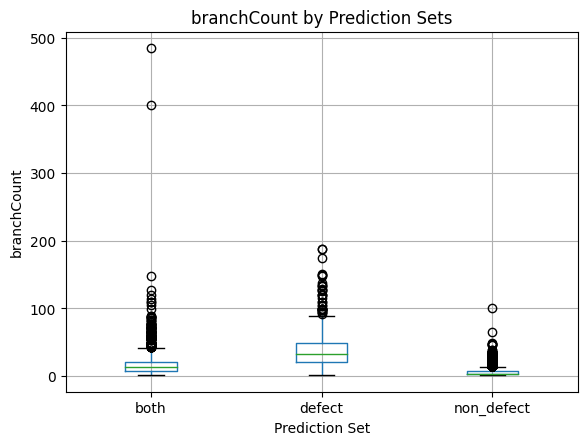

In [31]:
for f in X_val.columns:
    temp = pd.concat([val_summary[['prediction_group']], X_val[f]], axis=1)
    
    temp.boxplot(by='prediction_group')
    plt.suptitle('')
    plt.title('{} by Prediction Sets'.format(f))
    plt.xlabel('Prediction Set')
    plt.ylabel('{}'.format(f))
    plt.show()

It basically seems that for most features predictions of 'defect' have larger values than those with the 'non_defect' prediction. When the model is undertain, the distributions tend to lie in the middle of 'defect' and 'non_defect' distributions. Ideally, our data would be much more separated so this would be easier, but it's not the case as they tend to overlap quite a lot.

### How well are the prediction sets doing?

In [32]:
val_summary.groupby('prediction_group').agg({'y':['count','mean'],
                                             'yhat':'mean',
                                             'true_label_in_set':'mean'})

y                yhat true_label_in_set
                  count      mean      mean              mean
prediction_group                                             
both               3828  0.414577  0.442629          1.000000
defect              785  0.743949  0.864884          0.743949
non_defect        10652  0.121010  0.091405          0.878990

In [33]:
val_summary.groupby('y')['prediction_group'].value_counts()

y  prediction_group
0  non_defect          9363
   both                2241
   defect               201
1  both                1587
   non_defect          1289
   defect               584
Name: count, dtype: int64

It's not terrible from the looks of it. Obviously it would be nice if we had fewer examples that the model isn't sure about. And when it is sure, it would be great if the predicted 'defect' had a higher precision than 74%, but it's still not bad. When looking at recall, we see that slightly more than half the defects are in our 'both' or 'non_defect' prediction sets. That's a pretty big proportion of all defects. So we ideally would be able to capture a larger percentage of total defects.

## The Effect of the Size of the Calibration Set & Correct Coverage

#### Define Function for Conformal Process

In [34]:
def conformal(y, preds, scores, n_cal, alpha):
    ###################
    ### Data Splits ###
    ###################
    
    # randomly sort data
    N = len(y)
    randomized_indexes = np.random.permutation(N)
    
    # select indexes for cal/val sets
    cal_indexes = randomized_indexes[:n_cal]
    val_indexes = randomized_indexes[n_cal:]
    
    # calibration data needed
    cal_scores = scores[cal_indexes]
    
    # validation data needed
    y_val = y[val_indexes]
    val_preds = preds[val_indexes]
    val_scores = scores[val_indexes]
    
    ######################
    ### Calculate qhat ###
    ######################
    
    q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
    qhat=np.quantile(cal_scores, q_level, method='higher')
    
    ################################
    ### Generate Prediction Sets ###
    ################################
    
    prediction_sets = (val_preds >= (1-qhat)).astype(int)
    
    ###################################
    ### Calculate Marginal Coverage ###
    ###################################
    
    val_summary = pd.DataFrame({'y':y_val,
                                'yhat':val_preds[:, 1],
                                'non_defect_set':prediction_sets[:, 0],
                                'defect_set':prediction_sets[:, 1]})
    val_summary['set_size'] = val_summary[['non_defect_set','defect_set']].sum(axis=1)
    val_summary['prediction_group'] = val_summary[['non_defect_set','defect_set']].apply(lambda x: prediction_group(x[0],x[1]), axis=1)
    val_summary['true_label_in_set'] = val_summary[['y','prediction_group']].apply(lambda x: true_label_covered(x[0],x[1]), axis=1)
    
    marginal_coverage = np.round(np.mean(val_summary['true_label_in_set']), 3)
    
    return marginal_coverage

#### Split Data

In [35]:
# split out training data
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Train XGB

In [36]:
# train model once
# it will just be randomly selecting our cal/val sets
# from the 20% of the training data that was selected above
xgb = XGBClassifier(n_estimators=1000, 
                    learning_rate=0.1, 
                    max_depth=7, 
                    subsample=0.90,
                    n_jobs=-1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### Generate Scores

In [37]:
# Generate scores once on entire X_
# this is the 30% left aside to be
# split between calibration and validation sets
preds = xgb.predict_proba(X_)
y_ = np.array(y_)
scores = 1 - preds[np.arange(len(y_)), y_]

#### Conformal Process

In [38]:
%%time
Ns = [x for x in range(100, 1100, 100)]
coverages = {}
alpha = 0.1

# intialize coverages
for n in Ns:
    coverages['{}'.format(n)] = []

# for each calibration set size
for n in Ns:
    print('Calibration Set Size: {}'.format(n))
    # randomly split data into cal/val 100 times
    # will plot density for each sample size
    # Use X_ and y_ from train_test_split above
    for r in [x for x in range(0,100)]:
        coverage = conformal(y_, preds, scores, n, alpha)
        coverages['{}'.format(n)].append(coverage)
    
    c = np.round(np.mean(coverages['{}'.format(n)]), 3)
    print('Coverage of {}'.format(c))
    print('')

Calibration Set Size: 100
Coverage of 0.911

Calibration Set Size: 200
Coverage of 0.902

Calibration Set Size: 300
Coverage of 0.903

Calibration Set Size: 400
Coverage of 0.901

Calibration Set Size: 500
Coverage of 0.903

Calibration Set Size: 600
Coverage of 0.902

Calibration Set Size: 700
Coverage of 0.901

Calibration Set Size: 800
Coverage of 0.901

Calibration Set Size: 900
Coverage of 0.899

Calibration Set Size: 1000
Coverage of 0.9

CPU times: user 4min 7s, sys: 70.6 ms, total: 4min 8s
Wall time: 4min 8s


This shows us that we have correct coverage. On average we are hovering around the 90% coverage we want, even for different calibration set sizes from n=100-1000.

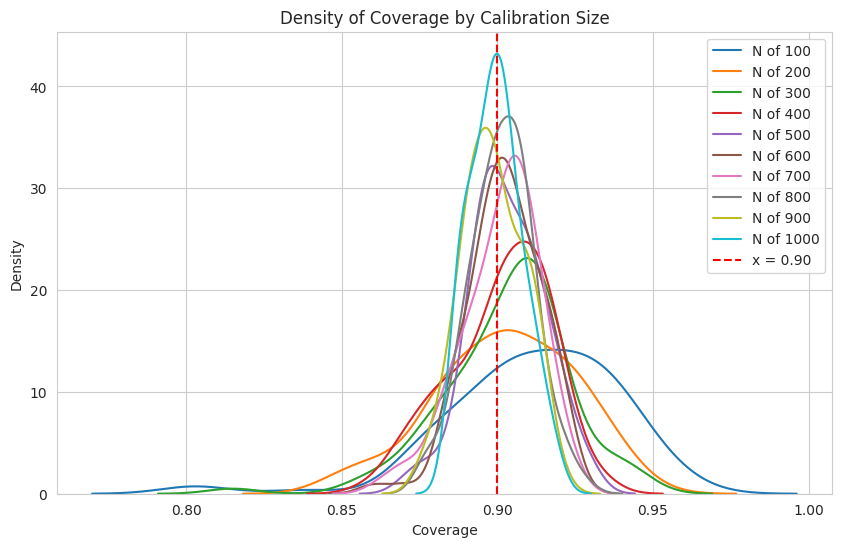

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the figure
plt.figure(figsize=(10,6))

# Loop over the values in Ns, plotting a density plot for each
for n in Ns:
    # Select the column corresponding to the current value of N
    # Assume coverages is a DataFrame where each column is a different group of data
    data = coverages[str(n)]
    
    # Plot the density plot
    sns.kdeplot(data, label=f'N of {n}')

# Set the title and labels of the plot
plt.title('Density of Coverage by Calibration Size')
plt.xlabel('Coverage')
plt.ylabel('Density')

plt.axvline(x=0.90, color='r', linestyle='--', label='x = 0.90')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

# Class-Conditional Conformal Prediction

Here we just need to split our calibration data into pos/neg classes and perform conformal process on both sets. So we will end up with a q-value for each set and apply accordingly. This process should help us realize our desired coverage on both classes. Above we saw 98% coverage on the negative class and 63% coverage on the positive class.

In [40]:
def conformal(y, preds, scores, n_cal, alpha):
    ###################
    ### Data Splits ###
    ###################
    
    # randomly sort data
    N = len(y)
    randomized_indexes = np.random.permutation(N)
    
    # select indexes for cal/val sets
    cal_indexes = randomized_indexes[:n_cal]
    val_indexes = randomized_indexes[n_cal:]
    
    # calibration data needed
    y_cal = y[cal_indexes]
    cal_scores = scores[cal_indexes]
    cal_df = pd.DataFrame({'y':y_cal,
                           'scores':cal_scores})
    
    pos = cal_df[cal_df['y'] == 1]
    neg = cal_df[cal_df['y'] == 0]
    
    # validation data needed
    y_val = y[val_indexes]
    val_preds = preds[val_indexes]
    val_scores = scores[val_indexes]
    
    ######################
    ### Calculate qhat ###
    ######################
    q_level_pos = np.ceil((pos.shape[0]+1)*(1-alpha))/pos.shape[0]
    q_level_neg = np.ceil((neg.shape[0]+1)*(1-alpha))/neg.shape[0]
    
    qhat_pos=np.quantile(pos['scores'], q_level_pos, method='higher')
    qhat_neg=np.quantile(neg['scores'], q_level_neg, method='higher')
    
    ################################
    ### Generate Prediction Sets ###
    ################################
    
    prediction_set_pos = (val_preds[:, 1] >= (1-qhat_pos)).astype(int)
    prediction_set_neg = (val_preds[:, 0] >= (1-qhat_neg)).astype(int)
    
    ###################################
    ### Calculate Marginal Coverage ###
    ###################################
    
    val_summary = pd.DataFrame({'y':y_val,
                                'yhat':val_preds[:, 1],
                                'non_defect_set':prediction_set_neg,
                                'defect_set':prediction_set_pos})
    val_summary['set_size'] = val_summary[['non_defect_set','defect_set']].sum(axis=1)
    val_summary['prediction_group'] = val_summary[['non_defect_set','defect_set']].apply(lambda x: prediction_group(x[0],x[1]), axis=1)
    val_summary['true_label_in_set'] = val_summary[['y','prediction_group']].apply(lambda x: true_label_covered(x[0],x[1]), axis=1)
    
    marginal_coverage = np.round(np.mean(val_summary['true_label_in_set']), 3)
    
    return val_summary, marginal_coverage

In [41]:
results_df, coverage = conformal(y_, preds, scores, 1000, 0.1)

In [42]:
coverage

0.903

In [43]:
results_df.groupby('y')['true_label_in_set'].agg(['count','mean'])

,count,mean
y,,
0,14957,0.904861
1,4396,0.895587


So now we see we have marginal coverage and class-conditioned coverage. Let's check to see if we have better prediction-conditioned and set size coverage.

In [44]:
results_df.groupby('set_size')['true_label_in_set'].agg(['count','mean'])

,count,mean
set_size,,
1,9272,0.797023
2,10081,1.000000


In [45]:
results_df.groupby('prediction_group')['true_label_in_set'].agg(['count','mean'])

,count,mean
prediction_group,,
both,10081,1.00000
defect,3373,0.57812
non_defect,5899,0.92219


In [46]:
val_summary.groupby('prediction_group')['true_label_in_set'].agg(['count','mean'])

,count,mean
prediction_group,,
both,3828,1.000000
defect,785,0.743949
non_defect,10652,0.878990


So we see a drastic change in predictions. The defect only prediction set doesn't get close to our 90% desired coverage. Below we had far fewer defect only predictions, which had much better coverage. We see that we end up moving a lot of the non_defect only predictions into both or defect prediction sets. So we get a little more precise in non_defect only, but at the cost of less precise defect only prediction sets, and much more predictions having less confident 'both' prediction sets.